## TP3 : Logistic regression 

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).


In [ ]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt

from numpy import linalg as la

## 1. Logistic regression, IRLS algorithm.

IRLS : Iteratively reweighted least squares

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below. 

In [ ]:
def regression_logistique(X,t,Nitermax=50,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximal d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    
    N_train = X.shape[0]

    ## initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],))  # le vecteur de la régression logistique est de la taille du nombre d'attributs du set + terme du biais
    w_old = w 
    y = 1/2*np.ones((N_train,))   # y correspond  à la probabilité de la classe 0 sachant X (les données d'entrée) --> sous la forme de la fonction sigmoïde 
                                  # on choisit la valeur 1/2 car c'est le maximum de la fonction y |--> y*(1-y) sur [0,1] 
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n)) correspond à la matrice hessienne de la log-vraisemblance. C'est une matrice de poids.
    z = X.dot(w_old)-la.inv(R).dot(y-t)  
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)  # pas de Newton
    
    # On cherche à maximiser la log-vraisemblance
    ## boucle appliquant l'algortihme de Newton-Raphson
    Niter = 1
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) ):  # on arrête d'itérer lorsque la convergence de w devient trop lente ou bien lorsque'on atteint le max d'itérations fixé
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w)))  # lorsque |W| devient très grand, y tend vers 0 ou 1 
        R = np.diag(y*(1-y))  # Si y est très proche de 1 ou 0, il devient difficile d'inverser R
        w_old = w 
        z = X.dot(w_old)-la.inv(R).dot(y-t) # On rencontre un problème ici si R n'est pas inversible
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z) 
         
    return w, Niter


**In the Newton algorithm :**
We have the following result  :

$\tilde{w} = \tilde{w}^{(old)} - (X^T RX)^{-1}.X^T RX(y-t) =(X^T RX)^{-1}.X^T R.z^{(old)}$ 

We recognize $(X^T RX)^{-1}.X^T R$ as quite similar to the Penrose inverse for least square regression.
Indeed the algorithm applies a reweigthed least square criterion.

In the previous Logistic Regression algorithm, we want to maximize the likelyhood $y$. 
If our data can be separated perfectly (linearly), we can set $w$, the logistic regression vector to infinity (see sigmoïd function below). In this way the prediction of class 1 or 2  will have a high value of probability. The prediction will be more accurate.
In the case, where $w$ is high, the hessian matrix of the likelyhood becomes singular. We cannot apply Logistic Regression*.

Using Logistic Regression with a penalty  $l^1$ can prevent $w$ from being too high.


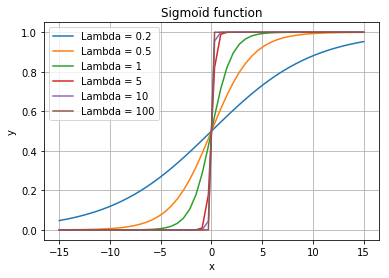

In [ ]:
x = np.linspace(-15,15,50)

plt.figure()

for i in [0.2,0.5,1,5,10,100]:
  Lambda = i
  y = 1 / (1 + np.exp(-Lambda * x))
  plt.plot(x,y,label = "Lambda = " + str(i))
  
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Sigmoïd function")
plt.legend()
plt.show()

### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [ ]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]  # give the index of variables from class 1
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)


### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [ ]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


Let's estimate the logistic function vector :

In [ ]:
w, Niter = regression_logistique(X, t)

## Decision function

Let's define the following decision function to get the classification results.

In [ ]:
def decision_function(w, sample):
  
  predicted_class = np.zeros(len(sample))
  
  for i in range(len(sample)) :
    sigma = 1 / ( 1 + np.exp( w.T.dot(sample[i])))

    if sigma >= 0.5 : 
      predicted_class[i] = 0
    else :
      predicted_class[i] = 1
        
  return predicted_class

In [ ]:
predicted_class_test = decision_function(w,X_test)

Let us compute the error on test set :

In [ ]:
predicted_class_test - t_test


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [ ]:
error_test = np.sum(np.abs(predicted_class_test - t_test)) / len(X_test)

Let us do this for the train set and compute the error : 

In [ ]:
predicted_class_train = decision_function(w,X)

In [ ]:
error_train = np.sum(np.abs(predicted_class_train - t)) / len(X)
error_train

0.03

We get a 3% error, which is quite good.

## Visual of the logistic regression : 

You can draw the decision boundary $w^Tx = 0$ by using: 


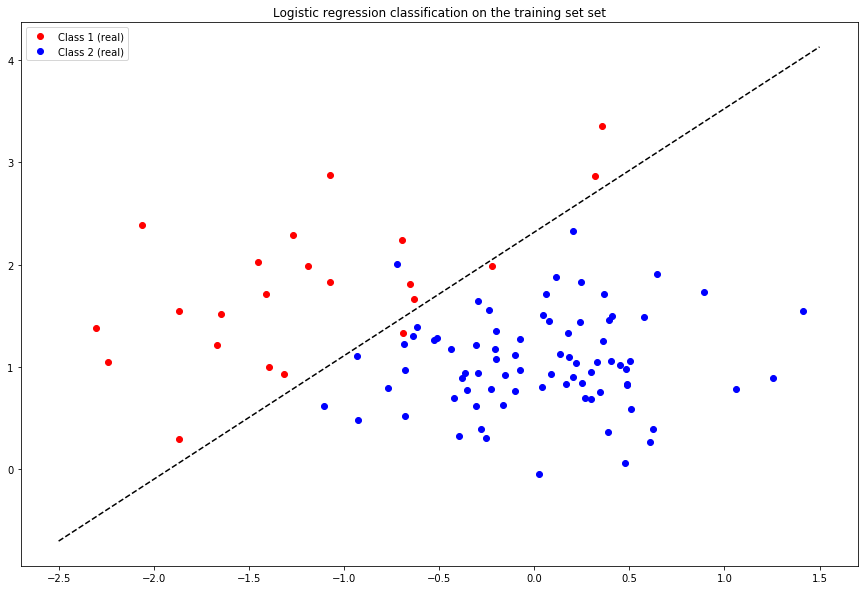

In [ ]:
plt.rcParams['figure.figsize'] = 15, 10

x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,x2,'k--')

plt.plot(synth_train[class_train_1][:,1] , synth_train[class_train_1][:,2], 'ro', label = 'Class 1 (real)')
plt.plot(synth_train[class_train_2][:,1] , synth_train[class_train_2][:,2], 'bo', label = 'Class 2 (real)')

plt.legend()
plt.title('Logistic regression classification on the training set set')
plt.show()

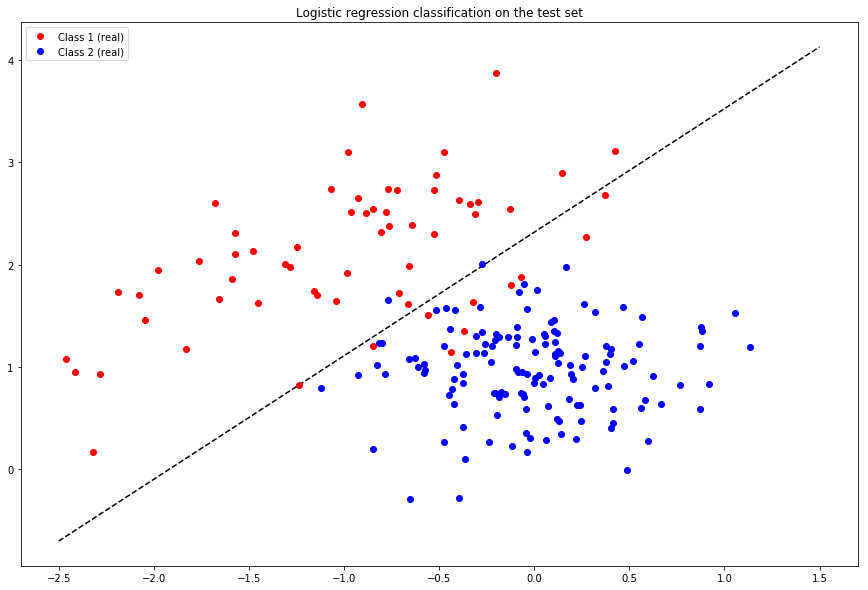

In [ ]:
plt.rcParams['figure.figsize'] = 15, 10

x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]

plt.plot(x1,x2,'k--')

plt.plot(synth_test[class_test_1][:,1] , synth_test[class_test_1][:,2], 'ro', label = 'Class 1 (real)')
plt.plot(synth_test[class_test_2][:,1] , synth_test[class_test_2][:,2], 'bo', label = 'Class 2 (real)')

plt.title('Logistic regression classification on the test set')
plt.legend()
plt.show()

In both cases, the separation boundary seems satisfactory.

Let us now display the predicted results.

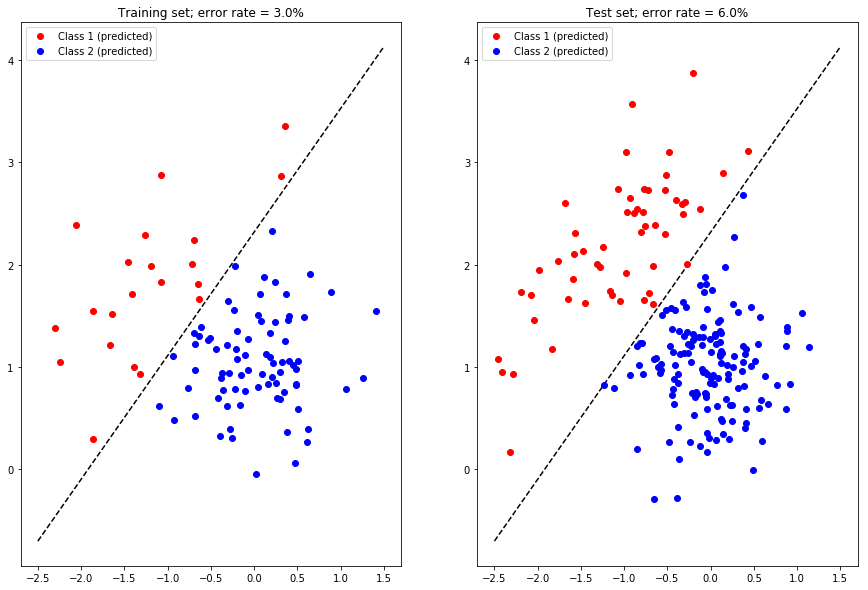

In [ ]:
plt.rcParams['figure.figsize'] = 15, 10

# For the training set
plt.subplot(1,2,1)
# Boundary
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,x2,'k--')
#plt.imshow(predicted_grid_LDA, extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)),cmap = "Pastel1")
# Predicted classes
plt.plot(synth_train[predicted_class_train == 1][:,1] , synth_train[predicted_class_train == 1][:,2], 'ro', label = 'Class 1 (predicted)')
plt.plot(synth_train[predicted_class_train == 0][:,1] , synth_train[predicted_class_train == 0][:,2], 'bo', label = 'Class 2 (predicted)')
plt.title("Training set; error rate = "+str(error_train*100)+"%")
plt.legend(loc='upper left')

# For the test set
plt.subplot(1,2,2)
# Boundary
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]
plt.plot(x1,x2,'k--')
#plt.imshow(predicted_grid_LDA, extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)),cmap = "Pastel1")
# Predicted classes
plt.plot(synth_test[predicted_class_test == 1][:,1] , synth_test[predicted_class_test == 1][:,2], 'ro', label = 'Class 1 (predicted)')
plt.plot(synth_test[predicted_class_test == 0][:,1] , synth_test[predicted_class_test == 0][:,2], 'bo', label = 'Class 2 (predicted)')
plt.title("Test set; error rate = "+str(error_test*100)+"%")
plt.legend(loc='upper left')

plt.show()

The classifier has correctly predicted 94% of the test set. This is satisfying result, given the low amount of trainig data.

## Checking robustness to outliers

In [ ]:
x_outliers = np.concatenate((synth_train,np.array([[2., -2.4 , 6.5], 
                                      [1., -2.5 , 6.9], 
                                      [1., -2 , 6.9], 
                                      [1., -2. , 6.8], 
                                      [1., -2.4 , 6.7], 
                                      [1., -2.2 , 6.9], 
                                      [1., -1.1 , 6.9], 
                                      [1., -1.8 , 7], 
                                      [1., -2. , 6.5], 
                                      [1., -2.25 , 6.7]])),axis = 0)
N_outliers = np.size(x_outliers,axis=0)

In [ ]:
t_outliers = 2-x_outliers[:,0]

In [ ]:
X_outliers = np.hstack((np.ones((N_outliers,1)),x_outliers[:,1:]))

In [ ]:
w_outliers , N_iter_outliers = regression_logistique(X_outliers,t_outliers)

Predicting on training set with `w_outliers` :

In [ ]:
predicted_class_train_outliers = decision_function(w_outliers, X_outliers)

In [ ]:
error_train_outliers = np.sum(np.abs(predicted_class_train_outliers - t_outliers)) / len(t_outliers)
error_train_outliers

0.07272727272727272

Predicting on test set with `w_outliers` : 

In [ ]:
predicted_class_test_outliers = decision_function(w_outliers,X_test)

In [ ]:
error_test_outliers = np.sum(np.abs(predicted_class_test_outliers - t_test)) / len(t_test)
error_test_outliers

0.1

Let's display the results

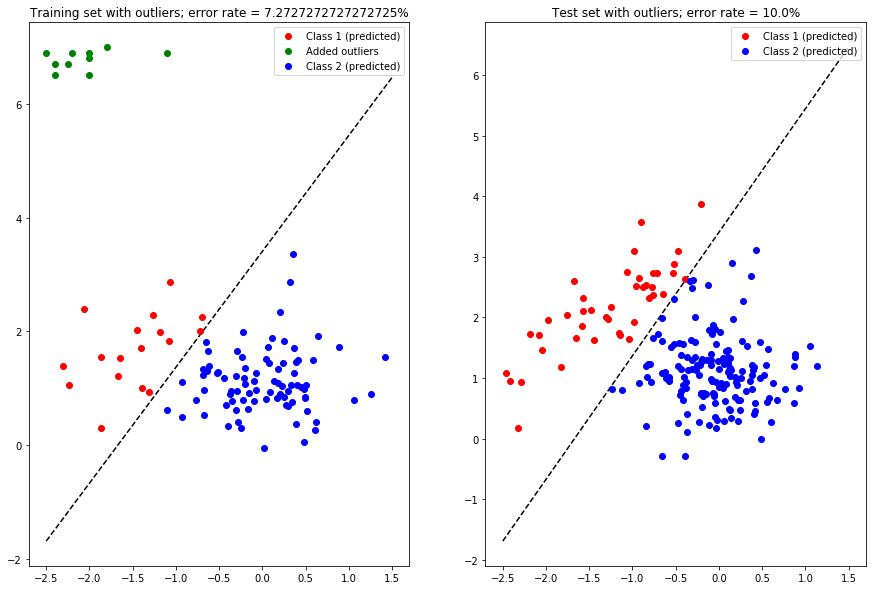

In [ ]:
plt.rcParams['figure.figsize'] = 15, 10

# For the training set
plt.subplot(1,2,1)
# Boundary
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w_outliers[0]-w_outliers[1]*x1)/w_outliers[2]
plt.plot(x1,x2,'k--')
#plt.imshow_outliers(predicted_grid_LDA, extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)),cmap = "Pastel1")
# Predicted classes
plt.plot(x_outliers[predicted_class_train_outliers == 1][:-10,1] , x_outliers[predicted_class_train_outliers == 1][:-10,2], 'ro', label = 'Class 1 (predicted)')
plt.plot(x_outliers[predicted_class_train_outliers == 1][-10:,1] , x_outliers[predicted_class_train_outliers == 1][-10:,2], 'go', label = 'Added outliers')
plt.plot(x_outliers[predicted_class_train_outliers == 0][:,1] , x_outliers[predicted_class_train_outliers == 0][:,2], 'bo', label = 'Class 2 (predicted)')
plt.title("Training set with outliers; error rate = "+str(error_train_outliers*100)+"%")
plt.legend(loc='upper right')

# For the test set
plt.subplot(1,2,2)
# Boundary
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w_outliers[0]-w_outliers[1]*x1)/w_outliers[2]
plt.plot(x1,x2,'k--')
#plt.imshow_outliers(predicted_grid_LDA, extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)),cmap = "Pastel1")
# Predicted classes
plt.plot(synth_test[predicted_class_test_outliers == 1][:,1] , synth_test[predicted_class_test_outliers == 1][:,2], 'ro', label = 'Class 1 (predicted)')
plt.plot(synth_test[predicted_class_test_outliers == 0][:,1] , synth_test[predicted_class_test_outliers == 0][:,2], 'bo', label = 'Class 2 (predicted)')
plt.title("Test set with outliers; error rate = "+str(error_test_outliers*100)+"%")
plt.legend(loc='upper right')

plt.show()

Logistic regression is robust to outliers. The boundary for the train set does not  lean towards the outliers.

Let's compare logistic regression to LDA : 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

In [ ]:
clf_lda = lda()
clf_lda.fit(x_outliers[:,1:],x_outliers[:,0])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [3]:
error_train_outliers_lda = 1-clf_lda.score(x_outliers[:,1:],x_outliers[:,0])
error_test_outliers_lda = 1-clf_lda.score(x_test,synth_test[:,0])

NameError: ignored

In [ ]:
pred_train_outliers_LDA = clf_lda.predict(x_outliers[:,1:])
pred_test_outliers_LDA = clf_lda.predict(x_test)

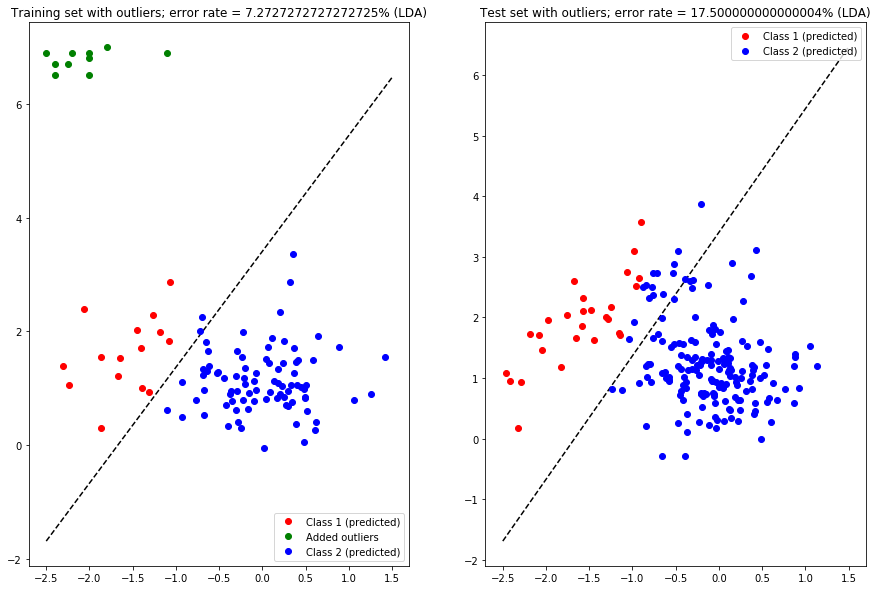

In [ ]:
plt.rcParams['figure.figsize'] = 15, 10

# For the training set
plt.subplot(1,2,1)
# Boundary
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w_outliers[0]-w_outliers[1]*x1)/w_outliers[2]
plt.plot(x1,x2,'k--')
#plt.imshow_outliers(predicted_grid_LDA, extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)),cmap = "Pastel1")
# Predicted classes
plt.plot(x_outliers[pred_train_outliers_LDA == 1][:-10,1] , x_outliers[pred_train_outliers_LDA == 1][:-10,2], 'ro', label = 'Class 1 (predicted)')
plt.plot(x_outliers[pred_train_outliers_LDA == 1][-10:,1] , x_outliers[pred_train_outliers_LDA == 1][-10:,2], 'go', label = 'Added outliers')
plt.plot(x_outliers[pred_train_outliers_LDA == 2][:,1] , x_outliers[pred_train_outliers_LDA == 2][:,2], 'bo', label = 'Class 2 (predicted)')
plt.title("Training set with outliers; error rate = "+str(error_train_outliers*100)+"% (LDA)")
plt.legend(loc='lower right')

# For the test set
plt.subplot(1,2,2)
# Boundary
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w_outliers[0]-w_outliers[1]*x1)/w_outliers[2]
plt.plot(x1,x2,'k--')
#plt.imshow_outliers(predicted_grid_LDA, extent = (np.min(x1),np.max(x1),np.min(x2),np.max(x2)),cmap = "Pastel1")
# Predicted classes
plt.plot(synth_test[pred_test_outliers_LDA == 1][:,1] , synth_test[pred_test_outliers_LDA == 1][:,2], 'ro', label = 'Class 1 (predicted)')
plt.plot(synth_test[pred_test_outliers_LDA == 2][:,1] , synth_test[pred_test_outliers_LDA == 2][:,2], 'bo', label = 'Class 2 (predicted)')
plt.title("Test set with outliers; error rate = "+str(error_test_outliers_lda*100)+"% (LDA)")
plt.legend(loc='upper right')

plt.show()

LDA is more sensitive to outliers. It shows on the prediction on the test set. The error is significantly higher than with logistic regression.

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [ ]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


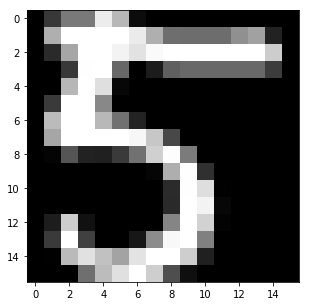

In [ ]:
# Digit 5
n=9; # showing a sample of the digit 5
I = np.reshape(train_5[n,:],(16,16))
plt.rcParams['figure.figsize'] = 7,5
plt.imshow(I,cmap='gray')
plt.show()

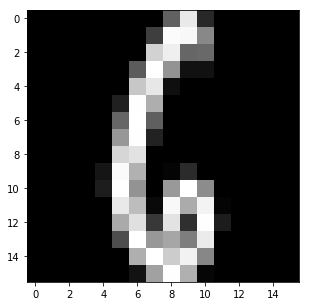

In [ ]:
# Digit 6
n=5;
I = reshape(train_6[n,:],(16,16))
plt.rcParams['figure.figsize'] = 7,5
plt.imshow(I,cmap='gray')
plt.show()

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [ ]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))  # stack values from both sets one baove the other
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


In [ ]:
# Exercise 2

In [ ]:
len(x_train_brut[1])

256

In [ ]:
print('The minimum value for a pixel is : ' , np.min(x_train_brut), "\nThe maximum value for a pixel is : ", np.max(x_train_brut))

The minimum value for a pixel is :  -1.0 
The maximum value for a pixel is :  1.0


Let's compute the standard deviation of each pixel for the x_train_brut set.

In [ ]:
sigma = np.std(x_train_brut, axis = 0)

We got 256 standard deviations, one for each of the 256 pixels in the image.

In [ ]:
len(sigma)

256

We select the indexes of the pixels with a standard deviation higher than 0.5.

In [ ]:
# list containing the indexes of the significant pixels
list_sig = np.nonzero(sigma >= 0.5)[0]

In [ ]:
list_sig

array([  7,   8,   9,  10,  11,  12,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  66,  67,  68,  69,
        70,  71,  72,  73,  82,  83,  84,  85,  86,  87,  88,  89,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 244, 245, 246, 247,
       248, 249, 250, 251], dtype=int64)

In [ ]:
len(list_sig)

173

Let's show the distribution of the high variance pixels.



[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]


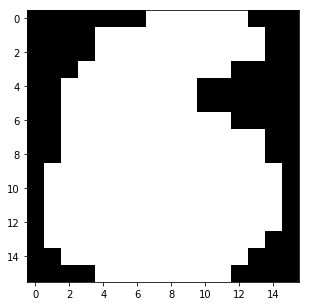

In [ ]:
Isig = np.zeros(256)
Isig[list_sig] = 1
print(Isig)
Isig = reshape(Isig,(16,16))
plt.rcParams['figure.figsize'] = 7,5
plt.imshow(Isig,cmap='gray')
plt.show()

We get the outline of a six and a five all together (white = significant pixels).
Indeed we selected the pixels that change the most from one image to another. By doing that we selected the pixels that give more information on wether the digit is a five or a six.

Let us select the significant features. We create new test and train sets.
We are applying a dimension reduction based on the feature significance (with the feature variance).

In [ ]:
x_train = x_train_brut[:,list_sig]
x_test = x_test_brut[:, list_sig]

In [ ]:
print("x_train image do have : ", shape(x_train)[1], " pixels. \nx_test do have : ", shape(x_test)[1], "pixels.")

x_train image do have :  173  pixels. 
x_test do have :  173 pixels.


In [1]:
shape(x_train)

NameError: ignored

Let's prepare the train and test sets : 

In [ ]:
# adding a columns of ones in the sets
X_train = np.hstack((np.ones((N_train,1)), x_train))
X_test = np.hstack((np.ones((N_test,1)), x_test))

Let's estimate the logistic regression vector with the Logistic Regression method.


The matrix R becomes singular after iterating too many times. We think it is because the value of $||w||$ becomes high after iterating too much. 

In [ ]:
w, Niter = regression_logistique(X_train,class_train.T[0],Nitermax=13,eps_conv=1e-3) # we needed to reshape class_train as an array from dimension (345,1) to (345,)

Let's apply the decision function to the test set : 

In [ ]:
predicted_class_test = decision_function(w,X_test)

The original test set labels are :

In [ ]:
class_test = np.ones(N_test) # assigning label 1 for digit 6
class_test[:len(train_5) - 145] = 0  # assigning label 0 for digit 5 (knowing that the 145 first images of 5 from train_5 are in the train set

Let's now compute the error rate on the digit prediction :

In [ ]:
error = np.sum(np.abs(class_test - predicted_class_test)) / N_test
error

0.07885714285714286

Let's visualize some mispredicted digits : 

In [ ]:
index_error = np.nonzero(class_test - predicted_class_test)
index_error

(array([ 27,  28,  60,  61,  81, 109, 127, 130, 131, 135, 145, 152, 153,
        156, 160, 177, 210, 212, 217, 227, 230, 243, 249, 263, 270, 277,
        293, 312, 313, 317, 324, 326, 333, 334, 340, 365, 367, 368, 378,
        379, 381, 382, 389, 396, 401, 416, 421, 429, 441, 452, 495, 512,
        532, 562, 568, 571, 573, 590, 609, 643, 655, 662, 724, 747, 794,
        832, 833, 841, 856], dtype=int64),)

In [ ]:
# mispredicted digit
n = 27 
print("This image is predicted : " , predicted_class_test[n], " but is class : ", class_test[n])

This image is predicted :  1.0  but is class :  0.0


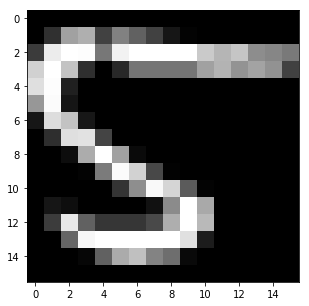

In [ ]:
n=27; 
I = np.reshape(x_test_brut[n,:],(16,16))
plt.rcParams['figure.figsize'] = 7,5
plt.imshow(I,cmap='gray')
plt.show()

The digit is predicted as a '6' but is a '5'.

In [ ]:
# mispredicted digit
n = 609 
print("This image is predicted : " , predicted_class_test[n], " but is class : ", class_test[n])

This image is predicted :  0.0  but is class :  1.0


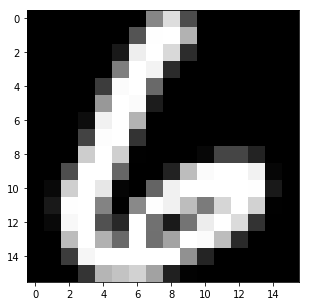

In [ ]:
n=609; 
I = np.reshape(x_test_brut[n,:],(16,16))
plt.rcParams['figure.figsize'] = 7,5
plt.imshow(I,cmap='gray')
plt.show()

The digit is predicted as a '5' but is a '6'. 

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Training on train set
clf = LogisticRegression(solver = 'newton-cg', max_iter = 13)
clf.fit(x_train, class_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=13, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
# Predicting on test set
predicted_class_scikit = clf.predict(x_test)

In [ ]:
# Compute error on prediction
1 - clf.score(x_test,class_test)

0.026285714285714246

In [ ]:
# Error with the programmed algorithm
error


0.07885714285714286

The error of the scikit-learn prediction is lower than with the algorithm we programmed (with similar parameters) : 2,6 % of error for the scikit-learn model, compared to 7,9 % of error with the programmed algorithm.

We test the scikit-learn Logistic Regression on the raw data (with no prior significant features selection).
We expect a worse prediction, but only by a small margin as the scikit-learn logisitic regression applies a $l^{1}$ penalty by default. Such a penalty induces a sparse regression vector.

In [ ]:
# Training on train set
clf = LogisticRegression(solver = 'newton-cg', max_iter = 13)
clf.fit(x_train_brut, class_train) 

# Predicting on test set
predicted_class_scikit = clf.predict(x_test_brut)

# Compute error on prediction
1 - clf.score(x_test_brut,class_test)

0.02857142857142858

This is not a surprising result. The $l^1$ penalty created sparcity on the features (selected the significant features).

For the digit set prediction, we have noticed that iterating too much within the Logistic Regression algorithm leads to $R$ becoming singular. We assume our training data set is linearly separable. Therefore by iterating the Newton algorithm, we increased the value of $w$ that made $R$ singular.
We could have tested applying a $l^1$ penalty to the likelyhood in order to avoid this issue.